Check against Parker's calculations.

The formula I use is:
$
Energy flux = \rho_0*g*<(\int v_{barotropic}(t,x)*H(x)*\eta(t,x)*dx))>
$

where $H$ is depth of a water column, $\eta$ is sea surface height, $v_{barotropic}$ is depth-averaged $y$ current, $g$ is acceleration due to gravity, $\rho_0$ is a reference density (1035 kg/m$^3$), and $<>$ represents a time average

In [1]:
import numpy as np
import xarray as xr
import netCDF4 as nc

import matplotlib.pyplot as plt
%matplotlib inline

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed',)).History will not be written to the database.


In [2]:
time_slice = slice('2015-01-01 00:00:00', '2016-01-01 00:00:00')
j=700

In [3]:
surf =xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSnSurfaceTracerFields1hV1') 

ssh_ts = (
    surf.ssh
    .isel(gridY=j,)
    .sel(time=time_slice)
)
ssh_ts.shape

(8760, 398)

In [4]:
v = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSn3DvVelocity1hV1')

v_ts = (
    v.vVelocity
    .isel(gridY=slice(j, j+2),)
    .sel(time=time_slice)
)
v_ts.shape

(8760, 40, 2, 398)

In [5]:
u = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSn3DuVelocity1hV1')

u_ts = (
    u.uVelocity
    .isel(gridY=j,)
    .sel(time=time_slice)
)
u_ts.shape

(8760, 40, 398)

In [6]:
mask3d = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSn3DMeshMask2V1') 

e3t = (
       mask3d.e3t
        .isel(gridY=j))
tmask = (
        mask3d.tmask
        .isel(gridY=j))


In [7]:
mask2d= xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSn2DMeshMask2V1')

e1t = (
       mask2d.e1t
        .isel(gridY=j))
e1t.shape

(40, 398)

In [8]:
mesh = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/mesh_mask_SalishSea2.nc')
e1t=mesh.variables['e1t'][..., j,:]

In [9]:
# unstagger v
v_us =np.mean(v_ts.values,axis=2)
v_us.shape
# barotropic v
H = np.sum(e3t.values*tmask.values,axis=1) # depth
vbar = np.divide( np.sum(v_us*e3t.values*tmask.values, axis=1), H) # depth average
vbar = np.nan_to_num(vbar)*tmask.values[:,0,:] #remove NaNs

0.0


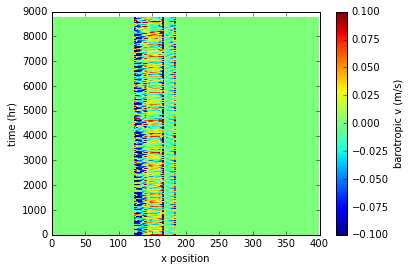

In [10]:
mesh=plt.pcolormesh(vbar,vmin=-.1,vmax=.1)
cbar = plt.colorbar(mesh)
cbar.set_label('barotropic v (m/s)')
print(vbar[0,0])
plt.ylabel('time (hr)')
plt.xlabel('x position')

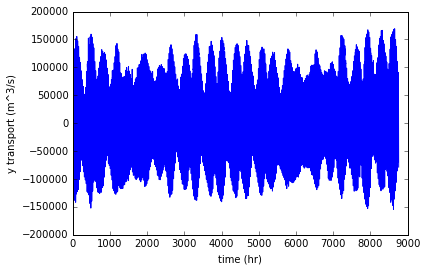

In [11]:
# transport
transport_bar = (vbar*H*e1t) # barotropic transport in each column
transport_sum = np.sum(transport_bar, axis=-1) # total
plt.plot(transport_sum)
plt.ylabel('y transport (m^3/s)')
plt.xlabel('time (hr)')

In [12]:
# Energy flux
rho0=1035 #kg/m^3
g=9.81 # m/s^2
ef = g*rho0*np.mean(np.sum(transport_bar*ssh_ts.values,axis=-1)) # barotropic energy flux (W)
print(ef)

290528713.277


In [13]:
mask2d= xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSn2DMeshMask2V1')

e2t = (
       mask2d.e2t)
print(e2t.isel(gridY=700))

RuntimeError: NetCDF: DAP failure

In [14]:
e1t = (
       mask2d.e1t)
print(e1t.isel(gridY=700))

RuntimeError: NetCDF: DAP failure

In [15]:
e3t_test = e3t = (
       mask3d.e3t)
print(e3t.isel(gridY=700))

<xarray.DataArray 'e3t' (t: 1, gridZ: 40, gridX: 398)>
array([[[  1.00000115,   1.00000115,   1.00000115, ...,   1.00000115,
           1.00000115,   1.00000115],
        [  1.00000501,   1.00000501,   1.00000501, ...,   1.00000501,
           1.00000501,   1.00000501],
        [  1.00001253,   1.00001253,   1.00001253, ...,   1.00001253,
           1.00001253,   1.00001253],
        ..., 
        [ 26.93002054,  26.93002054,  26.93002054, ...,  26.93002054,
          26.93002054,  26.93002054],
        [ 26.93157752,  26.93157752,  26.93157752, ...,  26.93157752,
          26.93157752,  26.93157752],
        [ 26.93237697,  26.93237697,  26.93237697, ...,  26.93237697,
          26.93237697,  26.93237697]]])
Coordinates:
  * t        (t) int32 0
  * gridZ    (gridZ) int16 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
    gridY    int16 700
  * gridX    (gridX) int16 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
Attributes:
    long_name: grid spacing on T-grid in w dir